In [510]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import cv2
from numpy.lib.stride_tricks import sliding_window_view
import torch.nn as nn
import torch
from scipy.interpolate import interp1d


In [511]:
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [512]:
def adaptive_normalization(signal, window_size=256):
    normalized = np.zeros_like(signal)

    for i in range(len(signal)):
        start = max(0, i - window_size // 2)
        end = min(len(signal), i + window_size // 2)

        local_mean = np.mean(signal[start:end])
        local_std = np.std(signal[start:end])

        normalized[i] = (signal[i] - local_mean) / local_std
        
    return normalized

In [513]:
def compute_windowed_mean(spectrogram):
    window_width = spectrogram.shape[0]
    windows = sliding_window_view(spectrogram, window_shape=window_width, axis=1)
    
    return np.mean(windows, axis=(0, 2))


In [514]:
def norm_spgrm(img):
    mean = np.mean(img)
    centered = img - mean
    std = np.std(centered)
    return centered / std

In [515]:
def spgrm(ppg, min_fr=0, max_fr=3):
    frequencies, _, Zxx = signal.stft(ppg, fs=256, window='hann', nperseg=1024, noverlap=1000)

    # log_spectrogram = 20 * np.log10(np.abs(Zxx) + 1e-10)
    log_spectrogram = np.abs(Zxx)
    freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)
    img = norm_spgrm(log_spectrogram[freq_mask, : ])

    return img


In [516]:
def conv(img):
    kernel_row = np.array(
        [[-1, -1, -1, -1, -1, -1, -1, -1, -1],
        # [-1, -1, -1, -1, -1, -1, -1, -1, -1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        # [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]],
     dtype=np.float32)

    conv1 = cv2.filter2D(img, -1, kernel_row)
    # conv2 = cv2.filter2D(conv1, -1, kernel_row)

    # relu = nn.ReLU()
    gelu = nn.GELU()
    activate = gelu(torch.Tensor(conv1))
    # activate = np.log10(relu(torch.Tensor(conv1)) + 1)

    return activate

In [517]:
def create_mask(min_amplitude, min_len_interval, in_signal, len_ppg):
    valid = (in_signal >= min_amplitude)
    
    diff = np.diff(valid.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if valid[0]:
        starts = np.insert(starts, 0, 0)
    if valid[-1]:
        ends = np.append(ends, len(valid))
    
    intervals = []
    for s, e in zip(starts, ends):
        if e - s >= min_len_interval:
            intervals.append((s, e))
    
    time_mask = np.zeros_like(valid, dtype=bool)
    for s, e in intervals:
        time_mask[s:e] = True

    indices_mask = np.arange(len(time_mask))
    indices_ppg = np.linspace(0, len(time_mask)-1, len_ppg)
    
    mask_func = interp1d(
        indices_mask,
        time_mask,
        kind='nearest',
        bounds_error=False,
        fill_value=False
    )
    
    return mask_func(indices_ppg).astype(bool)

In [ ]:
data = pd.read_csv('/home/ilya/Documents/stress-level-by-PPG/dataframe/test_movie_2.csv')

ppg_sr = 256
sec_with = 1000
num_sec = 500

ppg_md = data["afe_LED1ABSVAL"][sec_with * ppg_sr: (sec_with + num_sec) * ppg_sr]


In [ ]:
ppg_filt = bandpass_filter(ppg_md, 0.8, 4, ppg_sr)
adapt_ppg = adaptive_normalization(ppg_filt, 256)

wight = len(adapt_ppg) / 512
img = spgrm(adapt_ppg)
out = conv(img)
mean_fr = compute_windowed_mean(out)
mask = create_mask(4, 64, mean_fr, len(adapt_ppg))
filt_ppg = adapt_ppg.copy()
filt_ppg[~mask] = 0

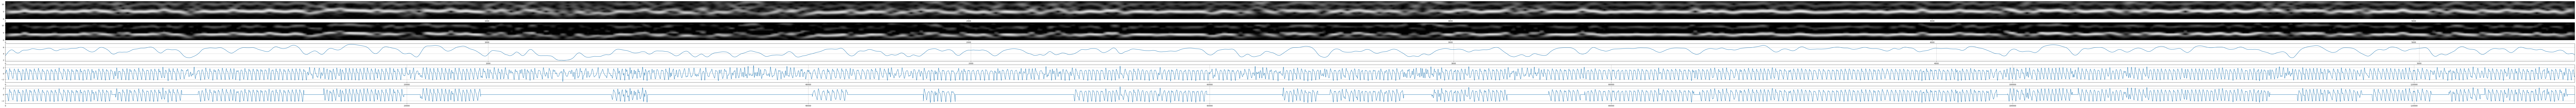

In [520]:
plt.figure(figsize=(wight, 10))

n = 5

plt.subplot(n, 1, n-4)
plt.pcolormesh(img, shading='gouraud', cmap='gray')

plt.subplot(n, 1, n-3)
plt.pcolormesh(out, shading='gouraud', cmap='gray')

plt.subplot(n, 1, n-2)
plt.plot(mean_fr)
plt.grid(True)
plt.margins(x=0)

plt.subplot(n, 1, n-1)
plt.plot(adapt_ppg)
plt.grid(True)
plt.margins(x=0)

plt.subplot(n, 1, n)
plt.plot(filt_ppg)
plt.grid(True)
plt.margins(x=0)

plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/spgrm_conv.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [521]:
# plt.figure(figsize=(wight, 7))

# plt.subplot(2, 1, 1)
# plt.plot(band_ppg)
# plt.grid(True)
# plt.margins(x=0)
# plt.ylim(-4000, 4000)

# plt.subplot(2, 1, 2)
# plt.plot(filt_ppg)
# plt.grid(True)
# plt.margins(x=0)
# plt.ylim(-4000, 4000)

# plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/spgrm_conv.png', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()